In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1,)

In [3]:
X_train = mnist.data[:60000]
X_test = mnist.data[60000:]
y_train = mnist.target[:60000]
y_test = mnist.target[60000:]

In [4]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [6]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_one_hot, train_size=0.8)

In [7]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# 【問題1】全結合層のクラス化

In [8]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        initialize_function = initializer(n_nodes1)
        self.optimizer = optimizer()
        self.W = initialize_function.init_weight(n_nodes1, n_nodes2)
        self.B = initialize_function.init_bias(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

# 【問題2】初期化方法のクラス化

In [9]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :重み
        """
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :バイアス
        """
        B = self.sigma*np.random.randn(1, n_nodes2)
        
        return B

# 【問題3】最適化手法のクラス化

In [10]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer

# 【問題4】活性化関数のクラス化

In [11]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = 1/(1 + np.exp(-self.A))
        
        return Z
    
    def backward(self, dZ):
        dA = dZ*(1 - self.A)*self.A
        
        return dA

In [12]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = np.tanh(A)
        
        return Z
    
    def backward(self, dZ):
        dA = dZ*(1 - np.tanh(self.A)**2)
        
        return dA

In [13]:
class SoftmaxWithLoss:
    def __init__(self):
        pass
    
    def forward(self, A):
        A -= np.max(A, axis=-1, keepdims=True)
        self.softmax = np.exp(A)/np.sum(np.exp(A), axis=-1, keepdims=True)
        
        return self.softmax
    
    def backward(self, y):
        loss = -np.sum(y*np.log(self.softmax + 1e-7))/y.shape[0]
        dA = self.softmax - y
        
        return loss, dA

# 【問題5】ReLUクラスの作成

In [14]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, A):
        self.mask = (A <=0)
        Z = A.copy()
        Z[self.mask] = 0
        
        return Z
    
    def backward(self, dZ):
        dZ[self.mask] = 0
        dA = dZ
        
        return dA

# 【問題6】重みの初期値

In [15]:
class XavierInitializer:
    def __init__(self, n_nodes1):
        self.sigma = 1/np.sqrt(n_nodes1)
        
    def init_weight(self, n_nodes1, n_nodes2):
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def init_bias(self, n_nodes2):
        B = self.sigma*np.random.randn(1, n_nodes2)
        
        return B

In [16]:
class HeInitializer:
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(2/n_nodes1)
        
    def init_weight(self, n_nodes1, n_nodes2):
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def init_bias(self, n_nodes2):
        B = self.sigma*np.random.randn(1, n_nodes2)
        
        return B

# 【問題7】最適化手法

In [17]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h_W = 0
        self.h_B = 0
        
    def update(self, layer):
        self.h_W += layer.dW**2
        self.h_B += layer.dB**2
        layer.W -= self.lr*layer.dW/np.sqrt(self.h_W + 1e-7)
        layer.B -= self.lr*layer.dB/np.sqrt(self.h_B + 1e-7)
        
        return layer

# 【問題8】クラスの完成

In [18]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, epochs=10, verbose=True):
        self.epoch = epochs
        self.verbose = verbose
        self.layers = {}
        self.layers['Affine1'] =  FC(784, 400, XavierInitializer, SGD)
        self.layers['Activation1'] = Tanh()
        self.layers['Affine2'] =  FC(400, 200, HeInitializer, SGD)
        self.layers['Activation2'] = Relu()
        self.layers['Affine3'] =  FC(200, 10, HeInitializer, SGD)
        self.last_layer = SoftmaxWithLoss()
        
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_list = []
        self.loss_epoch_list = []
        self.loss_val_epoch_list = []
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=i)
            loss_tmp_list = []
            for X_batch, y_batch in get_mini_batch:
                for layer in self.layers.values():
                    X_batch = layer.forward(X_batch)
                softmax = self.last_layer.forward(X_batch)
                loss, dA = self.last_layer.backward(y_batch)
                self.loss_list.append(loss)
                loss_tmp_list.append(loss)
                layers = list(self.layers.values())
                layers.reverse()
                for layer in layers:
                    dA = layer.backward(dA)
                    
            epoch_mean_loss = np.mean(loss_tmp_list)
            self.loss_epoch_list.append(epoch_mean_loss)
            if self.verbose:
                print(epoch_mean_loss)
            if X_val is not None and y_val is not None:
                X_val_copy = X_val.copy()
                for layer in self.layers.values():
                    X_val_copy = layer.forward(X_val_copy)
                softmax_val = self.last_layer.forward(X_val_copy)
                loss_val = -np.sum(y_val*np.log(softmax_val + 1e-7))/y_val.shape[0]
            self.loss_val_epoch_list.append(loss_val)
                    
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        self.last_layer.forward(X)
        y_pred = np.argmax(self.last_layer.softmax, axis=1)
        
        return y_pred

# 【問題9】学習と推定

In [19]:
scr_dnnc = ScratchDeepNeuralNetrowkClassifier()

In [20]:
scr_dnnc.fit(X_tr, y_tr, X_val, y_val)

0.2339422046012845
0.11291701796962414
0.08646956049754337
0.06399257648350275
0.051043704701758605
0.04081957141773256
0.03648029060421991
0.026982324830177866
0.024063102863745717
0.02017606089741549


accuracy_score:0.9761666666666666


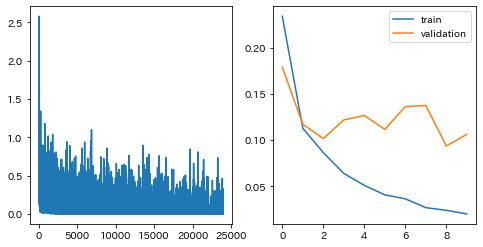

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(scr_dnnc.loss_list)
ax[1].plot(scr_dnnc.loss_epoch_list, label='train')
ax[1].plot(scr_dnnc.loss_val_epoch_list, label='validation')
ax[1].legend()
y_pred = scr_dnnc.predict(X_val)
y_val_label = np.argmax(y_val, axis=1)
accuracy = accuracy_score(y_val_label, y_pred)
print('accuracy_score:{}'.format(accuracy))

## 層と活性化関数とoptimizerを変えてみる

In [23]:
class ScratchDeepNeuralNetrowkClassifier_AdaGrad:
    def __init__(self, epochs=10, verbose=True):
        self.epoch = epochs
        self.verbose = verbose
        self.layers = {}
        self.layers['Affine1'] =  FC(784, 400, XavierInitializer, AdaGrad)
        self.layers['Activation1'] = Tanh()
        self.layers['Affine2'] =  FC(400, 200, XavierInitializer, AdaGrad)
        self.layers['Activation2'] = Sigmoid()
        self.layers['Affine3'] =  FC(200, 100, HeInitializer, AdaGrad)
        self.layers['Activation2'] = Relu()
        self.layers['Affine3'] =  FC(200, 10, HeInitializer, AdaGrad)
        self.last_layer = SoftmaxWithLoss()
        
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_list = []
        self.loss_epoch_list = []
        self.loss_val_epoch_list = []
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=i)
            loss_tmp_list = []
            for X_batch, y_batch in get_mini_batch:
                for layer in self.layers.values():
                    X_batch = layer.forward(X_batch)
                softmax = self.last_layer.forward(X_batch)
                loss, dA = self.last_layer.backward(y_batch)
                self.loss_list.append(loss)
                loss_tmp_list.append(loss)
                layers = list(self.layers.values())
                layers.reverse()
                for layer in layers:
                    dA = layer.backward(dA)
                    
            epoch_mean_loss = np.mean(loss_tmp_list)
            self.loss_epoch_list.append(epoch_mean_loss)
            if self.verbose:
                print(epoch_mean_loss)
            if X_val is not None and y_val is not None:
                X_val_copy = X_val.copy()
                for layer in self.layers.values():
                    X_val_copy = layer.forward(X_val_copy)
                softmax_val = self.last_layer.forward(X_val_copy)
                loss_val = -np.sum(y_val*np.log(softmax_val + 1e-7))/y_val.shape[0]
            self.loss_val_epoch_list.append(loss_val)
                    
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        self.last_layer.forward(X)
        y_pred = np.argmax(self.last_layer.softmax, axis=1)
        
        return y_pred

In [24]:
scr_dnnc_adagrad = ScratchDeepNeuralNetrowkClassifier_AdaGrad()

In [25]:
scr_dnnc_adagrad.fit(X_tr, y_tr, X_val, y_val)

0.20810097514351883
0.10068872970362312
0.07626730707935536
0.06165398467750866
0.05143348352212578
0.04458596977831997
0.03846525997178905
0.03376980434010303
0.029869326141410562
0.026557291361158773


accuracy_score:0.978


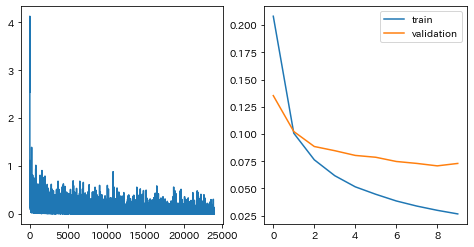

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(scr_dnnc_adagrad.loss_list)
ax[1].plot(scr_dnnc_adagrad.loss_epoch_list, label='train')
ax[1].plot(scr_dnnc_adagrad.loss_val_epoch_list, label='validation')
ax[1].legend()
y_pred_adagrad = scr_dnnc_adagrad.predict(X_val)
accuracy_adagrad = accuracy_score(y_val_label, y_pred_adagrad)
print('accuracy_score:{}'.format(accuracy_adagrad))

## validationデータからAdaGradの方がSGDに比べて過学習を起こしにくいと考えられる。